In [2]:
import os, shutil
import numpy as np
import pandas as pd
import random
import cv2
import sys
import glob 
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

import plotly.express as px
import plotly.graph_objects as go

import json

import torch
import colorama
from colorama import Fore

#from shapely.geometry import Polygon
import matplotlib.patches as patches

In [3]:
BASE_PATH = "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset"
TRAIN_PATH = os.path.join(BASE_PATH, "Train")
TEST_PATH = os.path.join(BASE_PATH, "Test")
SUPPLEMENTAL_PATH = os.path.join(BASE_PATH, "Supplemental content93")

print(os.listdir(BASE_PATH))

['Test', 'Train', 'Supplemental content93']


**Data PreProcessing**

In [4]:
pip install natsort

Note: you may need to restart the kernel to use updated packages.


In [5]:
import natsort
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
    def readPathes(self,):
      self.images = natsort.natsorted(list(pathlib.Path(self.imagesPathes).glob('*.*')))
      self.masks = natsort.natsorted(list(pathlib.Path(self.masksPathes).glob('*.*')))
    def readImages(self, data, typeData):
        images = []
        for img in data:
            img = cv2.imread(str(img), 0)
            img = img/255
            img = cv2.resize(img, (224, 224))
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            images.append(img)
        return np.array(images)
    def dataAugmentation(self, images, masks):
        imagesupdate = []
        masksupdate = []
        for image, mask in zip(images, masks):
          for aug in range(2):
            imageup = image
            maskup = mask
            if aug == 0:
              imageup = image
              maskup = mask
            else:
              imageup = tf.image.flip_left_right(imageup)
              maskup = tf.image.flip_left_right(maskup)
            imagesupdate.append(imageup), masksupdate.append(maskup)
        return np.array(imagesupdate), np.array(masksupdate)

In [6]:
datasetObject = readDataset("/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Train/images",
                            "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Train/mask")
datasetObject.readPathes()

In [7]:
len(datasetObject.images), len(datasetObject.masks)

(70, 70)

In [8]:
images = datasetObject.readImages(datasetObject.images, 'i')
masks = datasetObject.readImages(datasetObject.masks, 'm')
images.shape, masks.shape

((70, 224, 224), (70, 224, 224))

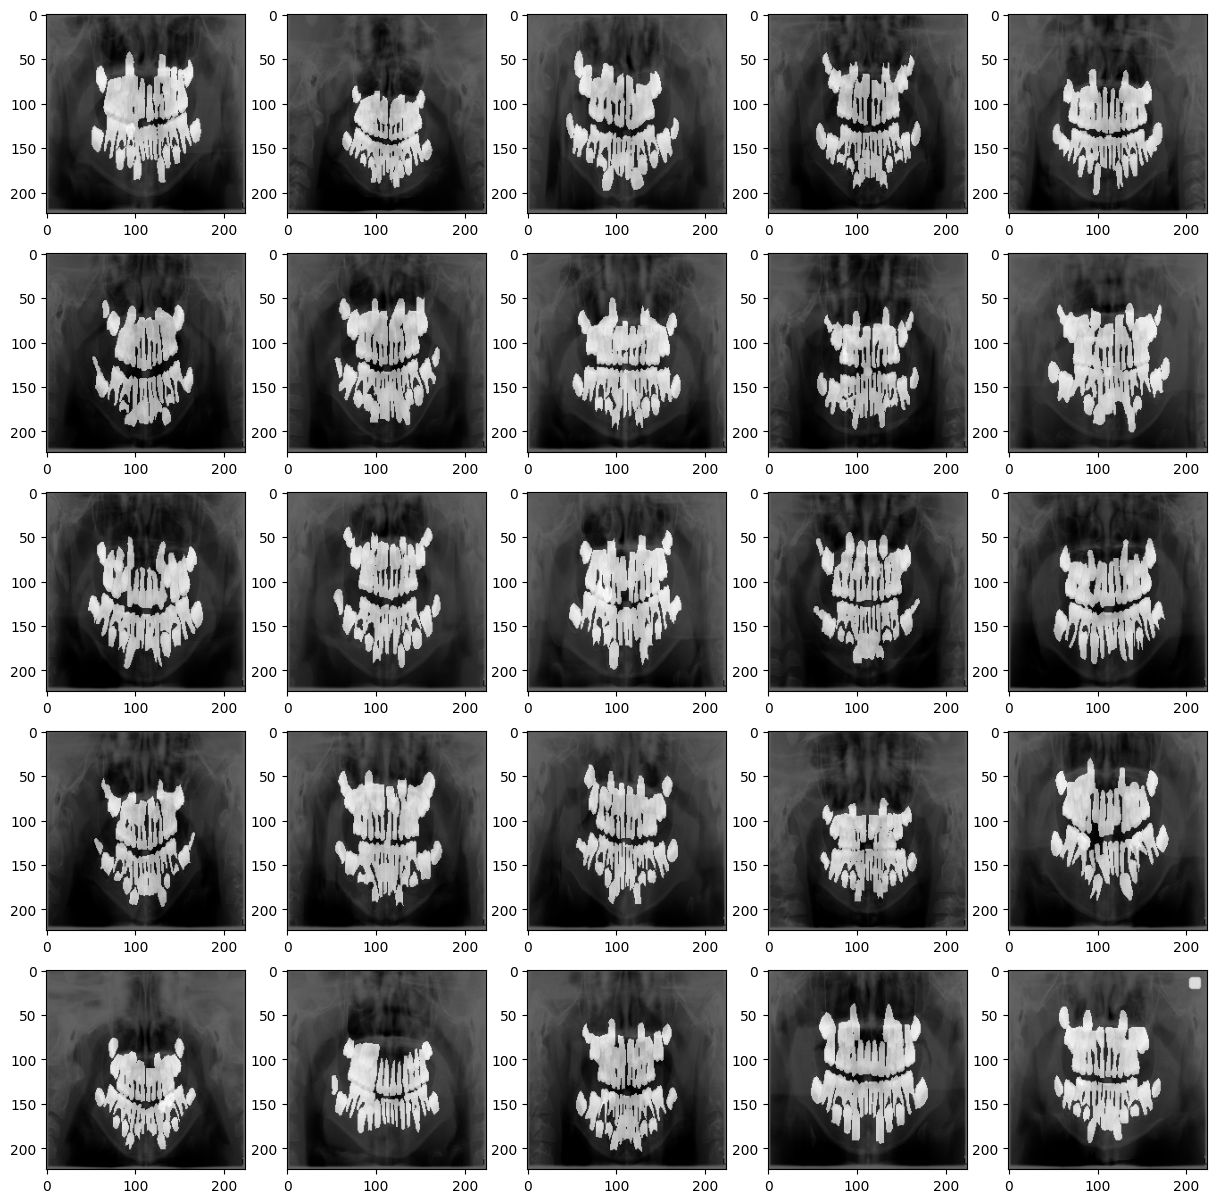

In [9]:
plt.figure(figsize = (15, 15))
for i in range(25):
    plt.subplot(5, 5, (i + 1))
    plt.imshow(images[i], cmap = 'gray')
    plt.imshow(masks[i], alpha = 0.6, cmap = 'gray')
plt.legend()

In [10]:
ANNOTATIONS_PATH = "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Train/annotations.json" 

with open(ANNOTATIONS_PATH, "r") as json_file:
    annot_json_file = json.load(json_file)

annot_json_file.keys()

dict_keys(['categories', 'images', 'annotations', 'info', 'licenses'])

In [ ]:
import json
from colorama import Fore

print("Keys of 'Categories' Property of Main JSON File:")
print(annot_json_file["categories"][0].keys(), end="\n\n")

print(Fore.MAGENTA + "Keys of 'Images' Property of Main JSON File:")
print(annot_json_file["images"][0].keys(), end="\n\n")

print(Fore.MAGENTA + "Keys of 'Annotations' Property of Main JSON File:")
print(annot_json_file["annotations"][0].keys(), end="\n\n")

print(Fore.BLACK + "'Info' Property of Main JSON File:")
print(annot_json_file["info"], end="\n\n")

print("'Licenses' Property of Main JSON File:")
print(annot_json_file["licenses"], end="\n")

# Extract all the category types (names) from the 'categories' property
category_types = [category["name"] for category in annot_json_file["categories"]]


Keys of 'Categories' Property of Main JSON File:
dict_keys(['id', 'name', 'color', 'supercategory'])

Keys of 'Images' Property of Main JSON File:
dict_keys(['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured'])

Keys of 'Annotations' Property of Main JSON File:
dict_keys(['id', 'iscrowd', 'image_id', 'category_id', 'segmentation', 'area', 'bbox'])

'Info' Property of Main JSON File:


'Licenses' Property of Main JSON File:
[]


In [ ]:
unique_category_types = list(set(category_types))

print(Fore.GREEN + "Unique Category Types in 'Categories' Property:")
for category_type in unique_category_types:
    print(category_type)


Unique Category Types in 'Categories' Property:
龋齿分割


In [13]:
category_translation = {
    "龋齿分割": "Caries Segmentation"
}
print(category_translation)

{'龋齿分割': 'Caries Segmentation'}


In [14]:
print("Amount of Images Samples:", len(annot_json_file["images"]))
print("Amount of Annotations Samples:", len(annot_json_file["annotations"]))

Amount of Images Samples: 70
Amount of Annotations Samples: 1258


In [15]:
annot_df = pd.DataFrame(annot_json_file["annotations"])
annot_df = annot_df.groupby(by="image_id").agg(lambda x: list(x)).reset_index()
annot_df["id_count"] = annot_df["id"].apply(len)
annot_df.head()


,image_id,id,iscrowd,category_id,segmentation,area,bbox,id_count
0,1,[1],[0],[1],"[[[1076.9520530949349, 481.9654168224754, 1075...",[344802.5098795295],"[[456.5902226503962, 183.0, 1092.4097773496037...",1
1,2,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[[694.0, 343.0, 677.0, 344.0, 662.0, 355.0, 6...","[4870.0, 6040.0, 43520.021957879886, 5091.5, 7...","[[649.0, 343.0, 91.0, 81.0], [553.0, 555.0, 97...",12
2,3,"[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[519.0, 179.0, 514.0, 180.0, 511.0, 183.0, 5...","[8741.0, 61247.5, 85991.5, 6616.5, 14520.0, 94...","[[474.0, 179.0, 91.0, 127.0], [987.0, 272.0, 3...",18
3,4,"[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[[572.0, 190.0, 560.0, 197.0, 555.0, 202.0, 5...","[5567.0, 10999.0, 33291.5, 5167.0, 21871.0, 66...","[[544.0, 187.0, 95.0, 104.0], [603.0, 255.0, 1...",16
4,5,"[48, 49, 50, 51, 52, 53, 54]","[0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1]","[[[720.0, 380.0, 716.0, 372.0, 713.0, 369.0, 7...","[131720.23946623504, 20020.0, 13328.5, 36734.0...","[[552.0, 265.0, 752.0, 302.0], [1285.0, 319.0,...",7


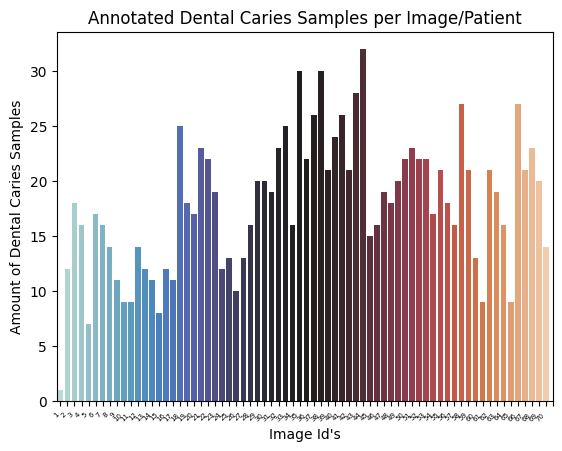

In [16]:
plt.title("Annotated Dental Caries Samples per Image/Patient")
sns.barplot(x=annot_df["image_id"].apply(str), y=annot_df["id_count"].apply(int), palette="icefire")
plt.xticks(range(71), rotation=45, ha='right', fontsize=5)
plt.xlabel('Image Id\'s')
plt.ylabel('Amount of Dental Caries Samples')
plt.show()

<Axes: title={'center': 'Frequency of Frequencies for id_count'}, xlabel='id_count', ylabel='count'>

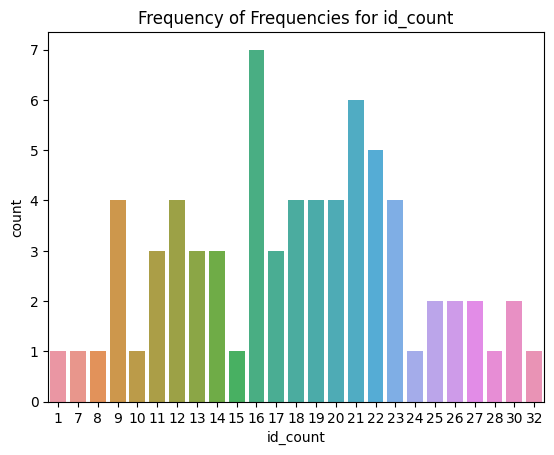

In [17]:
freqs = dict(zip(annot_df["image_id"], annot_df["id_count"]))
freqs_df = pd.DataFrame(list(freqs.items()), columns=["image_id", "id_count"])
plt.title("Frequency of Frequencies for id_count")
sns.countplot(freqs_df, x="id_count")

**FEATURE EXTRACTION**

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 174MB/s]  
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward 

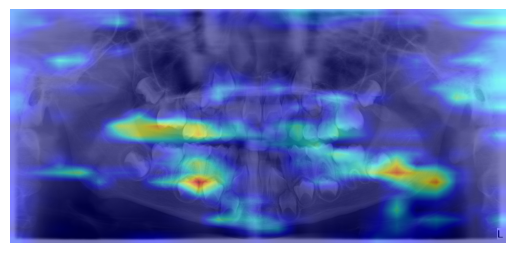

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn

model = maskrcnn_resnet50_fpn(pretrained=True)

def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((1024, 1024)),  
        transforms.ToTensor(),
    ])
    image = Image.open(img_path).convert('RGB')
    return preprocess(image).unsqueeze(0)  

image_path = "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Train/images/cate1_007.png"  # Replace with your image path
input_image = preprocess_image(image_path)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, target_index=None):
        output = self.model(input_tensor)[0]  
        
        if target_index is None:
            target_index = output['scores'].argmax().item()
        self.model.zero_grad()

        target_score = output['scores'][target_index]
        target_score.backward()

     
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3]) 
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)  
        heatmap /= heatmap.max()  
        return heatmap

target_layer = model.backbone.body.layer4[2]  
grad_cam = GradCAM(model, target_layer)
heatmap = grad_cam.generate_heatmap(input_image)

def overlay_heatmap(img_path, heatmap):
    original_img = Image.open(img_path).convert('RGB')
    heatmap_resized = Image.fromarray(np.uint8(heatmap * 255)).resize(original_img.size, Image.BILINEAR)
    heatmap_resized = np.array(heatmap_resized)

   
    heatmap_normalized = heatmap_resized / 255.0

    
    color_map = plt.cm.jet(heatmap_normalized)
    heatmap_colored = (color_map[:, :, :3] * 255).astype(np.uint8)  

    
    blended_image = np.array(original_img) * 0.5 + heatmap_colored * 0.5  


    plt.imshow(blended_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

overlay_heatmap(image_path, heatmap)


In [19]:
class SetupPipeline:
    @staticmethod
    def __pycocotools() -> None:
        if not os.path.exists("/kaggle/working/packages"):
            shutil.copytree("/kaggle/input/pycocotools-gav/", "/kaggle/working/packages")
            os.chdir("/kaggle/working/packages/pycocotools-2.0.6/")
            os.system("python setup.py install")
            os.system("pip install . --no-index --find-links /kaggle/working/packages/")
            os.chdir("/kaggle/working")
            
    @staticmethod
    def __detection_wheel() -> None:
        sys.path.append("/kaggle/input/detectionwheel")
            
    @staticmethod
    def __seed_everything(seed: int) -> None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        
    def __call__(self, seed: int = 42, pycoco: bool = True) -> None:
        self.__detection_wheel()
        if seed: self.__seed_everything(seed)
        if pycoco: self.__pycocotools()
            
setup = SetupPipeline()
SEED: int = 42
setup(seed=SEED, pycoco=True)

/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://github.com/py

Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx


./common/maskApi.c: In function 'rleToBbox':
./common/maskApi.c:151:32: warning: unused variable 'xp' [-Wunused-variable]
  151 |     uint h, w, xs, ys, xe, ye, xp, cc; siz j, m;
      |                                ^~
./common/maskApi.c: In function 'rleFrPoly':
./common/maskApi.c:197:3: warning: this 'for' clause does not guard... [-Wmisleading-indentation]
  197 |   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
      |   ^~~
./common/maskApi.c:197:54: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the 'for'
  197 |   for(j=0; j<k; j++) x[j]=(int)(scale*xy[j*2+0]+.5); x[k]=x[0];
      |                                                      ^
./common/maskApi.c:198:3: warning: this 'for' clause does not guard... [-Wmisleading-indentation]
  198 |   for(j=0; j<k; j++) y[j]=(int)(scale*xy[j*2+1]+.5); y[k]=y[0];
      |   ^~~
./common/maskApi.c:198:54: note: ...this statement, but the latter is misleadingly indented as if it wer

Looking in links: /kaggle/working/packages/
Processing /kaggle/working/packages/pycocotools-2.0.6
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=101952 sha256=073115c645417183ec9dd7e93cbc58dcf506f9210fb8763a20b261e033d94982
  Stored in directory: /root/.cache/pip/wheels/b7/83/32/99474500256e64154dfc568319411b6ff49e96e50f30d9474f
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


In [20]:
from pycocotools.coco import COCO

coco_annotation = COCO(annotation_file=ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
def show_bbox_image(idx: int):
    cat_ids = coco_annotation.getCatIds()
    query_id = cat_ids[0]
    cats = coco_annotation.loadCats(cat_ids)
    cat_names = [cat["name"] for cat in cats]
    query_name = cat_names[0]
    query_id = coco_annotation.getCatIds(catNms=[query_name])[0]
    img_ids = coco_annotation.getImgIds(catIds=[query_id])
    img_id = img_ids[idx]
    img_info = coco_annotation.loadImgs([img_id])[0]
    img_file_name = img_info["file_name"]
    img_url = img_info["coco_url"]
    print(
        f"Image ID: {img_id}, File Name: {img_file_name}, Image URL: {img_url}"
    )

    ann_ids = coco_annotation.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = coco_annotation.loadAnns(ann_ids)
    image = Image.open(os.path.join(TRAIN_PATH, f"images/{img_file_name}"))

    fig, ax = plt.subplots()

    for ann in anns:
        box = ann['bbox']
        bb = patches.Rectangle((box[0],box[1]), box[2],box[3], linewidth=1, edgecolor="red", facecolor="none")
        ax.add_patch(bb)

    ax.imshow(image)
    plt.show()

Image ID: 6, File Name: cate1_005.png, Image URL: 


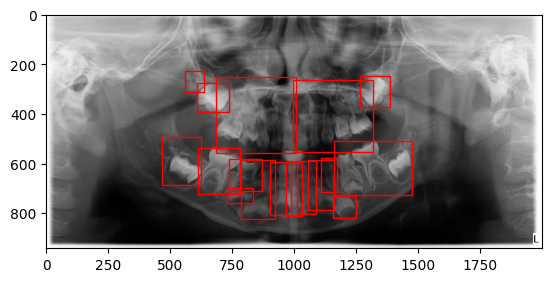

In [22]:
show_bbox_image(5)

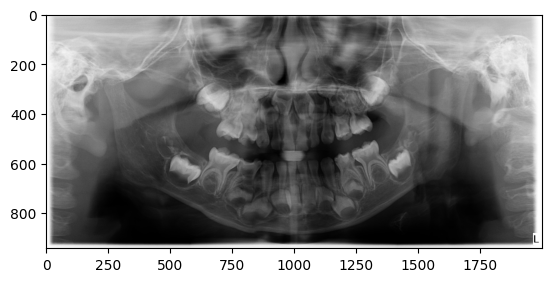

In [23]:
p5 = plt.imread("/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Train/images/cate1_005.png")
plt.imshow(p5)

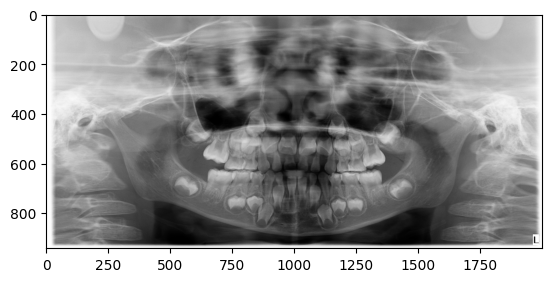

In [24]:
p6 = plt.imread("/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Test/images/cate1_006.png")
plt.imshow(p6)

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

**DATASET PREPARATION**

In [ ]:
from PIL import Image
from torchvision.transforms import functional as F

class ChildrenDentalRadiographsDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=get_transform):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.label_map = {
            1: "caries",
            2: "periapical infection",
            3: "others"
        }
        self.label_map2 = {
            "caries": 1,
            "periapical infection": 2,
            "others": 3
        }

    def __getitem__(self, idx):
        coco = self.coco
        image_id = self.ids[idx]
        ann_ids = coco.getAnnIds(imgIds=image_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(image_id)[0]["file_name"]
        img = Image.open(os.path.join(self.root, path)).convert("RGB")

        num_objs = len(coco_annotation)
        
        boxes = []
        labels = []
        masks = []
        areas = []

        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

            category_id = coco_annotation[i]['category_id']
            label = self.label_map2[self.label_map[category_id]]
            labels.append(label)
            mask = coco.annToMask(coco_annotation[i])
            masks.append(mask)
            areas.append(coco_annotation[i]['area'])
        
       
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        image_id = torch.tensor([image_id])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)


In [102]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(p=.5))
    return T.Compose(transforms)

In [103]:
TEST_ANNOTATIONS_PATH = "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Test/annotations.json"

In [104]:
train_ds = ChildrenDentalRadiographsDataset(root=os.path.join(TRAIN_PATH, "images"), annotation=ANNOTATIONS_PATH, transforms=get_transform(train=True))
val_ds = ChildrenDentalRadiographsDataset(root=os.path.join(TEST_PATH, "images"), annotation=TEST_ANNOTATIONS_PATH, transforms=get_transform(train=False))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


**MODEL TRAINING**

In [105]:
import utils
from engine import train_one_epoch

In [ ]:
import math
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


In [107]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True, collate_fn=utils.collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=os.cpu_count(), pin_memory=True, collate_fn=utils.collate_fn)

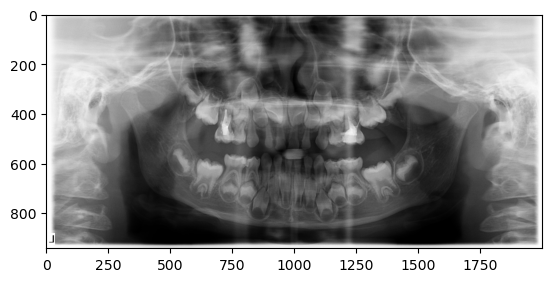

[{'boxes': tensor([[1039.,  276., 1437.,  547.],
        [ 957.,  350., 1067.,  585.],
        [ 545.,  278.,  701.,  449.],
        [ 679.,  257.,  968.,  547.],
        [1270.,  591., 1429.,  763.],
        [1409.,  567., 1508.,  675.],
        [1122.,  574., 1312.,  758.],
        [ 828.,  558., 1159.,  836.],
        [ 702.,  563.,  865.,  752.],
        [ 578.,  580.,  718.,  742.],
        [ 496.,  541.,  583.,  643.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  

In [ ]:
from torchvision import transforms

for images, labels in train_dl:

    img = transforms.ToPILImage()(images[0])
    plt.imshow(img)
    plt.show()
    print(labels)
    print(labels[0].keys())
    break

In [108]:
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.resnet import ResNet50_Weights

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone=ResNet50_Weights.IMAGENET1K_V2)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes)
    return model

In [109]:
from engine import evaluate
import utils

In [110]:
EPOCHS = 10

In [111]:
model = get_model_instance_segmentation(num_classes=3)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0003, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
def model_summary(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"{'Layer':<50} {'Output Shape':<30} {'Param #':<20}")
    print("=" * 100)
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  
            out_shape = "N/A" 
            param_count = sum(p.numel() for p in module.parameters())
            print(f"{name:<50} {out_shape:<30} {param_count:<20}")
    print("=" * 100)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {total_params - trainable_params}")

model = get_model_instance_segmentation(num_classes=3)
model.to(device)

model_summary(model)


Layer                                              Output Shape                   Param #             
transform                                          N/A                            0                   
backbone.body.conv1                                N/A                            9408                
backbone.body.bn1                                  N/A                            128                 
backbone.body.relu                                 N/A                            0                   
backbone.body.maxpool                              N/A                            0                   
backbone.body.layer1.0.conv1                       N/A                            4096                
backbone.body.layer1.0.bn1                         N/A                            128                 
backbone.body.layer1.0.conv2                       N/A                            36864               
backbone.body.layer1.0.bn2                         N/A                   

In [112]:
for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=20)
    evaluate(model, val_dl, device=device)
    scheduler.step()
    model_path = f"epoch_{epoch}.pth"
    torch.save(model.state_dict(), model_path)

/tmp/ipykernel_30/2430467288.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/35]  eta: 0:01:22  lr: 0.000009  loss: 4.1983 (4.1983)  loss_classifier: 1.0831 (1.0831)  loss_box_reg: 0.4467 (0.4467)  loss_mask: 1.4508 (1.4508)  loss_objectness: 1.1106 (1.1106)  loss_rpn_box_reg: 0.1071 (0.1071)  time: 2.3522  data: 1.3665  max mem: 10346
Epoch: [0]  [20/35]  eta: 0:00:14  lr: 0.000185  loss: 2.4898 (2.7146)  loss_classifier: 0.4616 (0.5904)  loss_box_reg: 0.6947 (0.6608)  loss_mask: 0.5860 (0.7820)  loss_objectness: 0.1869 (0.4495)  loss_rpn_box_reg: 0.0775 (0.2319)  time: 0.8748  data: 0.0004  max mem: 10346
Epoch: [0]  [34/35]  eta: 0:00:00  lr: 0.000300  loss: 1.4854 (2.2240)  loss_classifier: 0.3611 (0.4964)  loss_box_reg: 0.5824 (0.6180)  loss_mask: 0.3646 (0.6126)  loss_objectness: 0.1377 (0.3181)  loss_rpn_box_reg: 0.0422 (0.1789)  time: 0.9147  data: 0.0004  max mem: 10346
Epoch: [0] Total time: 0:00:32 (0.9382 s / it)
creating index...
index created!
Test:  [ 0/15]  eta: 0:00:51  model_time: 1.5878 (1.5878)  evaluator_time: 1.1059 (1.1059

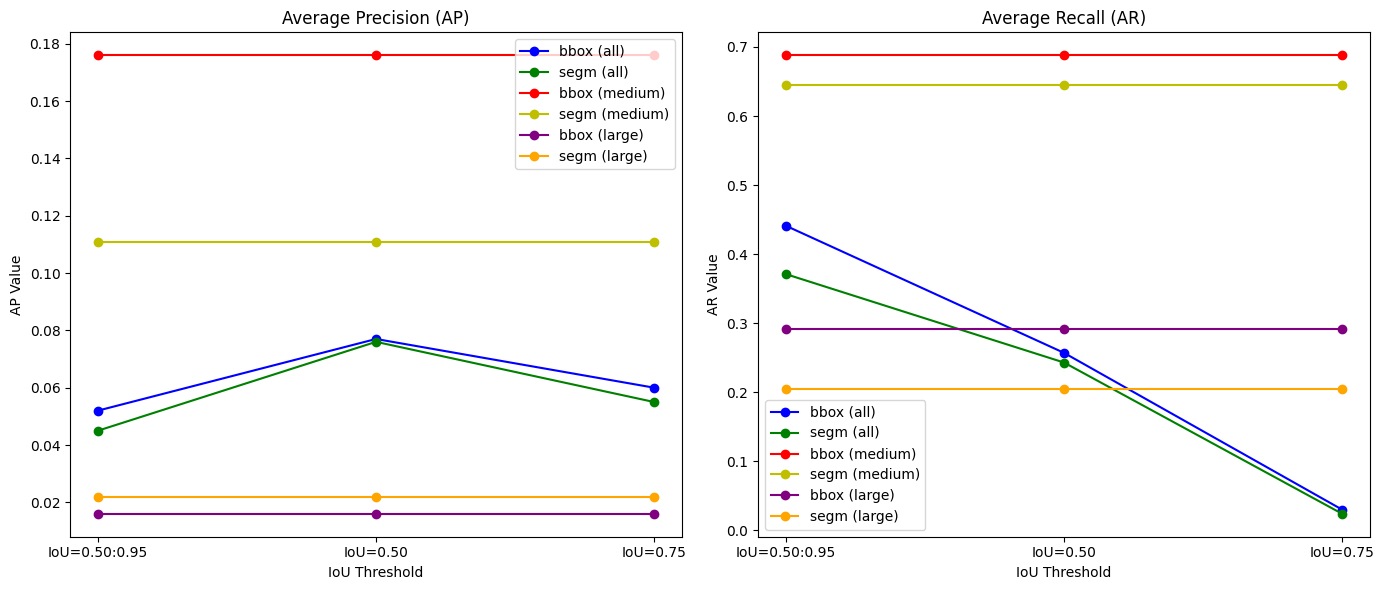

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['IoU=0.50:0.95', 'IoU=0.50', 'IoU=0.75']

precision_bbox = {
    'all': [0.052, 0.077, 0.060],
    'small': [-1.000, -1.000, -1.000],
    'medium': [0.176, 0.176, 0.176],
    'large': [0.016, 0.016, 0.016]
}

precision_segm = {
    'all': [0.045, 0.076, 0.055],
    'small': [-1.000, -1.000, -1.000],
    'medium': [0.111, 0.111, 0.111],
    'large': [0.022, 0.022, 0.022]
}

recall_bbox = {
    'all': [0.441, 0.257, 0.030],
    'small': [-1.000, -1.000, -1.000],
    'medium': [0.688, 0.688, 0.688],
    'large': [0.291, 0.291, 0.291]
}

recall_segm = {
    'all': [0.371, 0.243, 0.024],
    'small': [-1.000, -1.000, -1.000],
    'medium': [0.645, 0.645, 0.645],
    'large': [0.204, 0.204, 0.204]
}


fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(categories, precision_bbox['all'], marker='o', label='bbox (all)', color='b')
ax[0].plot(categories, precision_segm['all'], marker='o', label='segm (all)', color='g')
ax[0].plot(categories, precision_bbox['medium'], marker='o', label='bbox (medium)', color='r')
ax[0].plot(categories, precision_segm['medium'], marker='o', label='segm (medium)', color='y')
ax[0].plot(categories, precision_bbox['large'], marker='o', label='bbox (large)', color='purple')
ax[0].plot(categories, precision_segm['large'], marker='o', label='segm (large)', color='orange')

ax[0].set_title('Average Precision (AP)')
ax[0].set_xlabel('IoU Threshold')
ax[0].set_ylabel('AP Value')
ax[0].legend()

ax[1].plot(categories, recall_bbox['all'], marker='o', label='bbox (all)', color='b')
ax[1].plot(categories, recall_segm['all'], marker='o', label='segm (all)', color='g')
ax[1].plot(categories, recall_bbox['medium'], marker='o', label='bbox (medium)', color='r')
ax[1].plot(categories, recall_segm['medium'], marker='o', label='segm (medium)', color='y')
ax[1].plot(categories, recall_bbox['large'], marker='o', label='bbox (large)', color='purple')
ax[1].plot(categories, recall_segm['large'], marker='o', label='segm (large)', color='orange')

ax[1].set_title('Average Recall (AR)')
ax[1].set_xlabel('IoU Threshold')
ax[1].set_ylabel('AR Value')
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch

model = get_model_instance_segmentation(num_classes=3)

checkpoint_path = "/kaggle/working/epoch_9.pth"
model.load_state_dict(torch.load(checkpoint_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

print("Model loaded successfully!")


/tmp/ipykernel_30/4023620078.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Model loaded successfully!


In [ ]:
from PIL import Image

img_path = "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Test/images/cate1_005.png"
img = Image.open(img_path)

img_resized = img.resize((180, 180))

img_resized.show()  



/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpvsto03_9.PNG'


In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np

img_path = "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Test/images/cate1_005.png"
img = Image.open(img_path)

img = img.resize((180, 180))  

x = img_to_array(img)

x = np.expand_dims(x, axis=0)

img_data = preprocess_input(x)

print("Preprocessed Image Shape:", img_data.shape)


Preprocessed Image Shape: (1, 180, 180, 3)


In [ ]:
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image

checkpoint_path = "/kaggle/working/epoch_9.pth"
model = get_model_instance_segmentation(num_classes=3)
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


image_path = "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Test/images/cate1_005.png"  # Replace with your image path
img = Image.open(image_path).convert("RGB")  
transform = ToTensor() 
input_tensor = transform(img).unsqueeze(0).to(device)  

with torch.no_grad():
    outputs = model(input_tensor)

predicted_scores = outputs[0]['scores'].cpu().numpy()
predicted_classes = outputs[0]['labels'].cpu().numpy()  
predicted_boxes = outputs[0]['boxes'].cpu().numpy()  

print("Predicted Scores:", predicted_scores)
print("Predicted Classes:", predicted_classes)
print("Predicted Boxes:", predicted_boxes)


/tmp/ipykernel_30/2659772713.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Predicted Scores: [0.9922225  0.9907107  0.98932296 0.9857509  0.9808183  0.9754877
 0.9737579  0.9730944  0.9667194  0.96018034 0.9414784  0.93916553
 0.93761605 0.93536836 0.91533566 0.91200167 0.9073615  0.8942639
 0.8871237  0.8770968  0.8556783  0.7967165  0.74089634 0.7389911
 0.677895   0.6605667  0.6493176  0.5668177  0.4789482  0.2241404
 0.1967889  0.1843494  0.17433858 0.14925477 0.13850003 0.10137729
 0.08926604 0.083978   0.08025367 0.07301242 0.06700373 0.06605816
 0.05390756 0.05110941]
Predicted Classes: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
Predicted Boxes: [[ 748.1109   652.00616  831.1588   727.08124]
 [1328.8827   550.2235  1470.1702   696.0943 ]
 [ 653.4979   634.9822   729.05786  701.72363]
 [1461.5553   514.6569  1547.1113   611.68634]
 [ 527.58466  519.97925  670.5374   674.22314]
 [1144.9011   658.4676  1233.3109   727.4857 ]
 [1003.3714   267.4924  1206.442    559.0037 ]
 [1177.1844   294.6104  1439.8049   5

/tmp/ipykernel_30/571947800.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Predicted Scores: [0.9922225  0.9907107  0.98932296 0.9857509  0.9808183  0.9754877
 0.9737579  0.9730944  0.9667194  0.96018034 0.9414784  0.93916553
 0.93761605 0.93536836 0.91533566 0.91200167 0.9073615  0.8942639
 0.8871237  0.8770968  0.8556783  0.7967165  0.74089634 0.7389911
 0.677895   0.6605667  0.6493176  0.5668177  0.4789482  0.2241404
 0.1967889  0.1843494  0.17433858 0.14925477 0.13850003 0.10137729
 0.08926604 0.083978   0.08025367 0.07301242 0.06700373 0.06605816
 0.05390756 0.05110941]
Predicted Classes: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
Predicted Boxes: [[ 748.1109   652.00616  831.1588   727.08124]
 [1328.8827   550.2235  1470.1702   696.0943 ]
 [ 653.4979   634.9822   729.05786  701.72363]
 [1461.5553   514.6569  1547.1113   611.68634]
 [ 527.58466  519.97925  670.5374   674.22314]
 [1144.9011   658.4676  1233.3109   727.4857 ]
 [1003.3714   267.4924  1206.442    559.0037 ]
 [1177.1844   294.6104  1439.8049   5

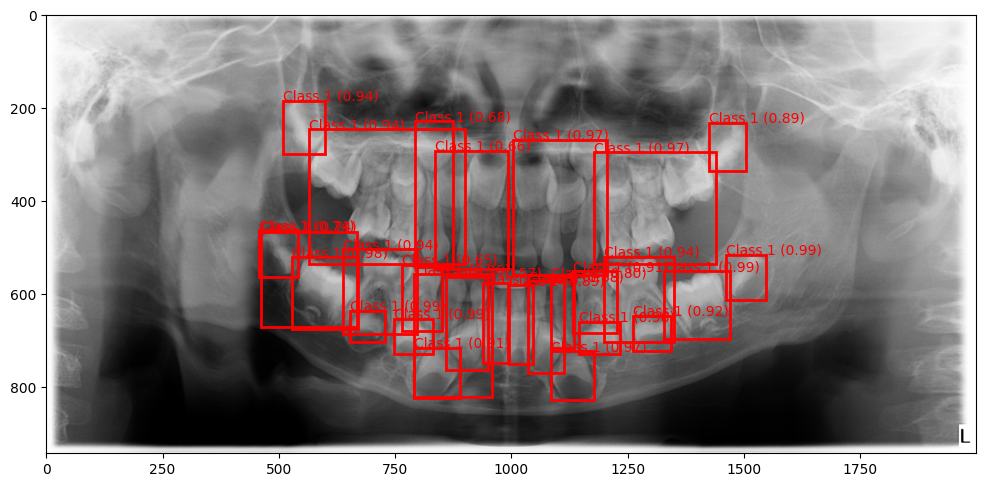

In [ ]:
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

checkpoint_path = "/kaggle/working/epoch_9.pth"
model = get_model_instance_segmentation(num_classes=3)
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = "/kaggle/input/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset/Test/images/cate1_005.png"  # Replace with your image path
img = Image.open(image_path).convert("RGB")  
transform = ToTensor()  
input_tensor = transform(img).unsqueeze(0).to(device)  

with torch.no_grad():
    outputs = model(input_tensor)

predicted_scores = outputs[0]['scores'].cpu().numpy()
predicted_classes = outputs[0]['labels'].cpu().numpy()  
predicted_boxes = outputs[0]['boxes'].cpu().numpy()  

print("Predicted Scores:", predicted_scores)
print("Predicted Classes:", predicted_classes)
print("Predicted Boxes:", predicted_boxes)

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)

score_threshold = 0.5  
for score, label, box in zip(predicted_scores, predicted_classes, predicted_boxes):
    if score > score_threshold:
        
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"Class {label} ({score:.2f})", fontsize=10, color='r')

plt.show()
